<a href="https://colab.research.google.com/github/dli-invest/dli-invest.github.io/blob/master/ibook/notebooks/analyze/pandas_ta_plots_ip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance yfinance
!pip install -U git+https://github.com/twopirllc/pandas-ta

  Cloning https://github.com/twopirllc/pandas-ta to /tmp/pip-req-build-grs1b0bb
  Running command git clone -q https://github.com/twopirllc/pandas-ta /tmp/pip-req-build-grs1b0bb
  Created wheel for pandas-ta: filename=pandas_ta-0.2.20b0-cp36-none-any.whl size=156778 sha256=db727bbd939c19b6e1dafebd4f45162132e2457150080e875dbca322b0509300
  Stored in directory: /tmp/pip-ephem-wheel-cache-svt9w119/wheels/64/67/96/15e918c3b53b4a323b5bd037c7f08be5ef6908141c50f07c76
Successfully built pandas-ta
  Found existing installation: pandas-ta 0.2.20b0
    Uninstalling pandas-ta-0.2.20b0:
      Successfully uninstalled pandas-ta-0.2.20b0


In [2]:
%matplotlib inline
import datetime as dt
import random as rnd

import numpy as np
import pandas as pd
import mplfinance as mpf
import pandas_ta as ta
import yfinance as yf

In [3]:
class Chart(object):
    def __init__(self, df: pd.DataFrame = None, strategy: ta.Strategy = ta.CommonStrategy, *args, **kwargs):
        self.verbose = kwargs.pop("verbose", False)

        if isinstance(df, pd.DataFrame) and df.ta.datetime_ordered:
            self.df = df
            if self.df.name is not None and self.df.name != "":
                df_name = str(self.df.name)
            else:
                df_name = "DataFrame"
            if self.verbose: print(f"[i] Loaded {df_name}{self.df.shape}")
        else:
            print(f"[X] Oops! Missing 'ohlcv' data or index is not datetime ordered.\n")
            return None

        self._validate_ta_strategy(strategy)
        self._validate_mpf_kwargs(**kwargs)
        self._validate_chart_kwargs(**kwargs)

        # Build TA and Plot
        self.df.ta.strategy(self.strategy, verbose=self.verbose)
        self._plot(**kwargs)

    def _validate_ta_strategy(self, strategy):
        if strategy is not None or isinstance(strategy, ta.Strategy):
            self.strategy = strategy
        elif len(self.strategy_ta) > 0:
            print(f"[+] Strategy: {self.strategy_name}")
        else:
            self.strategy = ta.CommonStrategy        

    def _validate_chart_kwargs(self, **kwargs):
        """Chart Settings"""
        self.config = {}
        self.config["last"] = kwargs.pop("last", recent_bars(self.df))
        self.config["rpad"] = kwargs.pop("rpad", 10)
        self.config["title"] = kwargs.pop("title", "Asset")
        self.config["volume"] = kwargs.pop("volume", True)

    def _validate_mpf_kwargs(self, **kwargs):
        # mpf global chart settings
        default_chart = mpf.available_styles()[-1]
        default_mpf_width = {
            'candle_linewidth': 0.6,
            'candle_width': 0.525,
            'volume_width': 0.525
        }
        mpfchart = {}

        mpf_style = kwargs.pop("style", "")
        if mpf_style == "" or mpf_style.lower() == "random":
            mpf_styles = mpf.available_styles()
            mpfchart["style"] = mpf_styles[rnd.randrange(len(mpf_styles))]
        elif mpf_style.lower() in mpf.available_styles():
            mpfchart["style"] = mpf_style

        mpfchart["figsize"] = kwargs.pop("figsize", (12, 10))
        mpfchart["non_trading"] = kwargs.pop("nontrading", False)
        mpfchart["rc"] = kwargs.pop("rc", {'figure.facecolor': '#EDEDED'})
        mpfchart["plot_ratios"] = kwargs.pop("plot_ratios", (12, 1.7))
        mpfchart["scale_padding"] = kwargs.pop("scale_padding", {'left': 1, 'top': 4, 'right': 1, 'bottom': 1})
        mpfchart["tight_layout"] = kwargs.pop("tight_layout", True)
        mpfchart["type"] = kwargs.pop("type", "candle")
        mpfchart["width_config"] = kwargs.pop("width_config", default_mpf_width)
        mpfchart["xrotation"] = kwargs.pop("xrotation", 15)
        
        self.mpfchart = mpfchart

    def _attribution(self):
        print(f"\nPandas v: {pd.__version__} [pip install pandas] https://github.com/pandas-dev/pandas")
        print(f"Data from Yahoo Finance v: 1.0.19 [pip install yfinance]")
        print(f"Technical Analysis with Pandas TA v: {ta.version} [pip install pandas_ta] https://github.com/twopirllc/pandas-ta")
        print(f"Charts by Matplotlib Finance v: {mpf.__version__} [pip install mplfinance] https://github.com/matplotlib/mplfinance\n")

    def _right_pad_df(self, rpad: int, delta_unit: str = "D", range_freq: str = "B"):
        if rpad > 0:
            dfpad = self.df[-rpad:].copy()
            dfpad.iloc[:,:] = np.NaN

            df_frequency = self.df.index.value_counts().mode()[0] # Most common frequency
            freq_delta = pd.Timedelta(df_frequency, unit=delta_unit)
            new_dr = pd.date_range(start=self.df.index[-1] + freq_delta, periods=rpad, freq=range_freq)
            dfpad.index = new_dr # Update the padded index with new dates
            self.df = self.df.append(dfpad)
        
            
    def _plot(self, **kwargs):
        if not isinstance(self.mpfchart["plot_ratios"], tuple):
            print(f"[X] plot_ratios must be a tuple")
            return

        # Override Chart Title Option
        chart_title = self.config["title"]
        if "title" in kwargs and isinstance(kwargs["title"], str):
            chart_title = kwargs.pop("title")

        # Override Right Bar Padding Option
        rpad = self.config["rpad"]
        if "rpad" in kwargs and kwargs["rpad"] > 0:
            rpad = int(kwargs["rpad"])

        def cpanel():
            return len(self.mpfchart['plot_ratios'])

        # Last Second Default TA Indicators
        linreg = kwargs.pop("linreg", False)
        linreg_name = self.df.ta.linreg(append=True).name if linreg else ""

        midpoint = kwargs.pop("midpoint", False)
        midpoint_name = self.df.ta.midpoint(append=True).name if midpoint else ""

        ohlc4 = kwargs.pop("ohlc4", False)
        ohlc4_name = self.df.ta.ohlc4(append=True).name if ohlc4 else ""

        clr = kwargs.pop("clr", False)
        clr_name = self.df.ta.log_return(cumulative=True, append=True).name if clr else ""

        rsi = kwargs.pop("rsi", False)
        rsi_length = kwargs.pop("rsi_length", None)
        if isinstance(rsi_length, int) and rsi_length > 1:
            rsi_name = self.df.ta.rsi(length=rsi_length, append=True).name
        elif rsi:
            rsi_name = self.df.ta.rsi(append=True).name
        else: rsi_name = ""
            
        zscore = kwargs.pop("zscore", False)
        zscore_length = kwargs.pop("zscore_length", None)
        if isinstance(zscore_length, int) and zscore_length > 1:
            zs_name = self.df.ta.zscore(length=zscore_length, append=True).name
        elif zscore:
            zs_name = self.df.ta.zscore(append=True).name
        else: zs_name = ""

        macd = kwargs.pop("macd", False)
        macd_name = ""
        if macd:
            macds = self.df.ta.macd(append=True)
            macd_name = macds.name

        squeeze = kwargs.pop("squeeze", False)
        lazybear = kwargs.pop("lazybear", False)
        squeeze_name = ""
        if squeeze:
            squeezes = self.df.ta.squeeze(lazybear=lazybear, detailed=True, append=True)
            squeeze_name = squeezes.name

        ama = kwargs.pop("archermas", False)
        ama_name = ""
        if ama:
            amas = self.df.ta.amat(append=True)
            ama_name = amas.name

        aobv = kwargs.pop("archerobv", False)
        aobv_name = ""
        if aobv:
            aobvs = self.df.ta.aobv(append=True)
            aobv_name = aobvs.name

        treturn = kwargs.pop("trendreturn", False)
        if treturn:
            # Long Trend requires Series Comparison (<=. <, = >, >=)
            # or Trade Logic that yields trends in binary.
            default_long = self.df["SMA_10"] > self.df["SMA_20"]
            long_trend = kwargs.pop("long_trend", default_long)
            short_trend = ~long_trend # Opposite/Inverse
            self.df["TRl"] = ta.trend_return(self.df["close"], long_trend, cumulative=True)
            self.df["TRs"] = ta.trend_return(self.df["close"], short_trend, cumulative=True)
            self.df["TR"] = self.df["TRl"] + self.df["TRs"]

        # Pad and trim Chart
        self._right_pad_df(rpad)
        mpfdf = self.df.tail(self.config["last"])
        mpfdf_columns = list(self.df.columns)

        # BEGIN: Custom TA Plots and Panels
        # Modify the area below 
        taplots = [] # Holds all the additional plots

        # Panel 0: Price Overlay
        if linreg_name in mpfdf_columns:
            taplots += [mpf.make_addplot(mpfdf[linreg_name], type=kwargs.pop("linreg_type", "line"), color=kwargs.pop("linreg_color", "black"), linestyle="-.", width=1.2, panel=0)]

        if midpoint_name in mpfdf_columns:
            taplots += [mpf.make_addplot(mpfdf[midpoint_name], type=kwargs.pop("midpoint_type", "scatter"), color=kwargs.pop("midpoint_color", "fuchsia"), width=0.4, panel=0)]

        if ohlc4_name in mpfdf_columns:
            taplots += [mpf.make_addplot(mpfdf[ohlc4_name], ylabel=ohlc4_name, type=kwargs.pop("ohlc4_type", "scatter"), color=kwargs.pop("ohlc4_color", "blue"), alpha=0.85, width=0.4, panel=0)]

        if self.strategy.name == ta.CommonStrategy.name:
            total_sma = 0 # Check if all the overlap indicators exists before adding plots
            for c in ["SMA_10", "SMA_20", "SMA_50", "SMA_200"]:
                if c in mpfdf_columns: total_sma += 1
                else: print(f"[X] Indicator: {c} missing!")
            if total_sma == 4:
                ta_smas = [
                    mpf.make_addplot(mpfdf["SMA_10"], color="green", width=1.5, panel=0),
                    mpf.make_addplot(mpfdf["SMA_20"], color="orange", width=2, panel=0),
                    mpf.make_addplot(mpfdf["SMA_50"], color="red", width=2, panel=0),
                    mpf.make_addplot(mpfdf["SMA_200"], color="maroon", width=3, panel=0),
                ]
                taplots += ta_smas

        if len(ama_name):
            amat_sr_ = mpfdf[amas.columns[-1]][mpfdf[amas.columns[-1]] > 0]
            amat_sr = amat_sr_.index.to_list()
        else:
            amat_sr = None

        # Panel 1: If volume=True, the add the VOL MA. Since we know there is only one, we immediately pop it.
        if self.config["volume"]:
            volma = [x for x in list(self.df.columns) if x.startswith("VOL_")].pop()
            max_vol = mpfdf["volume"].max()
            ta_volume = [mpf.make_addplot(mpfdf[volma], color="red", width=2, panel=1, ylim=(-.2 * max_vol, 1.5 * max_vol))]
            taplots += ta_volume

        # Panels 2 - 9
        common_plot_ratio = (3,)

        if len(aobv_name):
            _p = kwargs.pop("aobv_percenty", 0.2)
            aobv_ylim = ta_ylim(mpfdf[aobvs.columns[0]], _p)
            taplots += [
                mpf.make_addplot(mpfdf[aobvs.columns[0]], ylabel=aobv_name, color="black", width=1.5, panel=cpanel(), ylim=aobv_ylim),
                mpf.make_addplot(mpfdf[aobvs.columns[2]], color="silver", width=1, panel=cpanel(), ylim=aobv_ylim),
                mpf.make_addplot(mpfdf[aobvs.columns[3]], color="green", width=1, panel=cpanel(), ylim=aobv_ylim),
                mpf.make_addplot(mpfdf[aobvs.columns[4]], color="red", width=1.2, panel=cpanel(), ylim=aobv_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if clr_name in mpfdf_columns:
            _p = kwargs.pop("clr_percenty", 0.1)
            clr_ylim = ta_ylim(mpfdf[clr_name], _p)

            taplots += [mpf.make_addplot(mpfdf[clr_name], ylabel=clr_name, color="black", width=1.5, panel=cpanel(), ylim=clr_ylim)]
            if (1 - _p) * mpfdf[clr_name].min() < 0 and (1 + _p) * mpfdf[clr_name].max() > 0:
                taplots += [mpf.make_addplot(mpfdf["0"], color="gray", width=1.2, panel=cpanel(), ylim=clr_ylim)]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if rsi_name in mpfdf_columns:
            rsi_ylim = (0, 100)
            taplots += [
                mpf.make_addplot(mpfdf[rsi_name], ylabel=rsi_name, color=kwargs.pop("rsi_color", "black"), width=1.5, panel=cpanel(), ylim=rsi_ylim),
                mpf.make_addplot(mpfdf["20"], color="green", width=1, panel=cpanel(), ylim=rsi_ylim),
                mpf.make_addplot(mpfdf["50"], color="gray", width=0.8, panel=cpanel(), ylim=rsi_ylim),
                mpf.make_addplot(mpfdf["80"], color="red", width=1, panel=cpanel(), ylim=rsi_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel
        
        if macd_name in mpfdf_columns:
            _p = kwargs.pop("macd_percenty", 0.15)
            macd_ylim = ta_ylim(mpfdf[macd_name], _p)
            taplots += [
                mpf.make_addplot(mpfdf[macd_name], ylabel=macd_name, color="black", width=1.5, panel=cpanel()),#, ylim=macd_ylim),
                mpf.make_addplot(mpfdf[macds.columns[-1]], color="blue", width=1.1, panel=cpanel()),#, ylim=macd_ylim),
                mpf.make_addplot(mpfdf[macds.columns[1]], type="bar", alpha=0.8, color="dimgray", width=0.8, panel=cpanel()),#, ylim=macd_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel()),#, ylim=macd_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel            

        if zs_name in mpfdf_columns:
            _p = kwargs.pop("zascore_percenty", 0.2)
            zs_ylim = ta_ylim(mpfdf[zs_name], _p)
            taplots += [
                mpf.make_addplot(mpfdf[zs_name], ylabel=zs_name, color="black", width=1.5, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["-3"], color="red", width=1.2, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["-2"], color="orange", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["-1"], color="silver", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["1"], color="silver", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["2"], color="orange", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["3"], color="red", width=1.2, panel=cpanel(), ylim=zs_ylim)
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if squeeze_name in mpfdf_columns:
            _p = kwargs.pop("squeeze_percenty", 0.6)
            sqz_ylim = ta_ylim(mpfdf[squeeze_name], _p)
            taplots += [
                mpf.make_addplot(mpfdf[squeezes.columns[-4]], type="bar", color="lime", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[-3]], type="bar", color="green", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[-2]], type="bar", color="maroon", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[-1]], type="bar", color="red", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[4]], ylabel=squeeze_name, color="green", width=2, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[5]], color="red", width=1.8, panel=cpanel(), ylim=sqz_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if treturn:
            _p = kwargs.pop("treturn_percenty", 0.33)
            treturn_ylim = ta_ylim(mpfdf["TR"], _p)
            taplots += [
                mpf.make_addplot(mpfdf["TRl"], ylabel="Trend Return", type="bar", color="green", alpha=0.45, width=0.8, panel=cpanel(), ylim=treturn_ylim),
                mpf.make_addplot(mpfdf["TRs"], type="bar", color="red", alpha=0.45, width=0.8, panel=cpanel(), ylim=treturn_ylim),
                mpf.make_addplot(mpfdf["TR"], color="black", width=1.5, panel=cpanel(), ylim=treturn_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel(), ylim=treturn_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

            _p = kwargs.pop("cstreturn_percenty", 0.33)
            trcs = mpfdf["TR"].cumsum()
            treturncs_ylim = ta_ylim(trcs, _p)
            taplots += [
                mpf.make_addplot(trcs, ylabel="Trend B&H", color="black", width=1.5, panel=cpanel(), ylim=treturncs_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel(), ylim=treturncs_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        # END: Custom TA Plots and Panels

        if self.verbose:
            additional_ta = []
            chart_title  = f"{chart_title} [{self.strategy.name}] (last {self.config['last']} bars)"
            chart_title += f"\nSince {mpfdf.index[0]} till {mpfdf.index[-1]}"
            if len(linreg_name) > 0: additional_ta.append(linreg_name)
            if len(midpoint_name) > 0: additional_ta.append(midpoint_name)
            if len(ohlc4_name) > 0: additional_ta.append(ohlc4_name)
            if len(additional_ta) > 0:
                chart_title += f"\nIncluding: {', '.join(additional_ta)}"

        if amat_sr:
            vlines_ = dict(vlines=amat_sr, alpha=0.1, colors="red")
        else:
            # Hidden because vlines needs valid arguments even if None 
            vlines_ = dict(vlines=mpfdf.index[0], alpha=0, colors="white")

        # Create Final Plot
        mpf.plot(mpfdf,
            title=chart_title,
            type=self.mpfchart["type"],
            style=self.mpfchart["style"],
            datetime_format="%-m/%-d/%Y",
            volume=self.config["volume"],
            figsize=self.mpfchart["figsize"],
            tight_layout=self.mpfchart["tight_layout"],
            scale_padding=self.mpfchart["scale_padding"],
            panel_ratios=self.mpfchart["plot_ratios"], # This key needs to be update above if adding more panels
            xrotation=self.mpfchart["xrotation"],
            update_width_config=self.mpfchart["width_config"],
            show_nontrading=self.mpfchart["non_trading"],
            vlines=vlines_,
            addplot=taplots
        )
        
        self._attribution()

In [10]:
def get_prices_for_stock(stock, start_date="2019-03-01", end_date="2020-05-30"):
    data = yf.download(stock, start=start_date, end=end_date)
    data = data.fillna(method='ffill')
    # Drop columns with no entries
    data = data.dropna(axis='columns', how='all')
    return data

def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]
  
def ta_ylim(series: pd.Series, percent: float = 0.1):
    smin, smax = series.min(), series.max()
    if isinstance(percent, float) and 0 <= float(percent) <= 1:
        y_min = (1 + percent) * smin if smin < 0 else (1 - percent) * smin
        y_max = (1 - percent) * smax if smax < 0 else (1 + percent) * smax
        return (y_min, y_max)
    return (smin, smax)

ntar_df = get_prices_for_stock('NTAR.CN')
# Used for example Trend Return Long Trend Below
ntar_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
ntar_df.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume
Date,,,,,,
2019-03-01,0.55,0.55,0.52,0.52,0.52,18412
2019-03-04,0.54,0.54,0.51,0.54,0.54,57809
2019-03-05,0.55,0.55,0.50,0.51,0.51,72781
2019-03-06,0.52,0.53,0.50,0.50,0.50,36920
2019-03-07,0.54,0.54,0.52,0.54,0.54,35269


In [24]:

# Calculate Returns and append to the df DataFrame
ntar_df.ta.log_return(cumulative=True, append=True)
ntar_df.ta.percent_return(cumulative=True, append=True)
ntar_df.ta.rsi(cumulative=False, append=True)
ntar_df.head()
ntar_df.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'volume', 'SMA_10',
       'SMA_20', 'SMA_50', 'SMA_200', 'VOL_SMA_20', 'LR_14', 'CUMLOGRET_1',
       'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'AMAT_LR_2',
       'AMAT_SR_2', 'CUMPCTRET_1'],
      dtype='object')

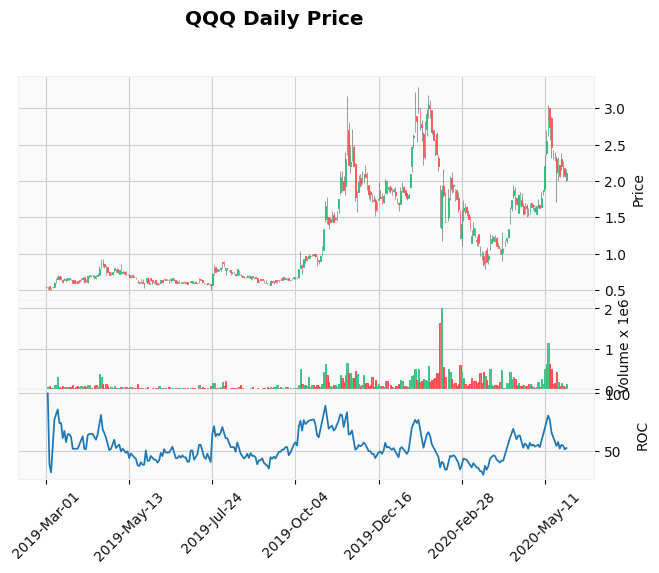

In [26]:

# We create an additional plot placing it on the third panel
roc_plot = mpf.make_addplot(ntar_df['RSI_14'], panel=2, ylabel='ROC')
#We pass the additional plot using the addplot parameter
mpf.plot(ntar_df, type='candle',  style='yahoo', addplot=roc_plot, title="Ntar Price Point", volume=True)

[*********************100%***********************]  1 of 1 completed
Index(['open', 'high', 'low', 'close', 'adj_close', 'volume', 'CUMLOGRET_1',
       'CUMPCTRET_1', 'RSI_14', 'PVOL'],
      dtype='object')


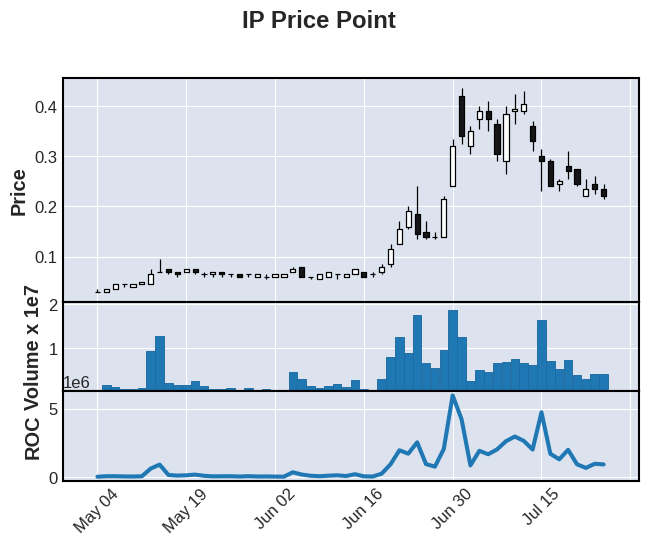

In [38]:
# IP analysis just before major increases in stock prices
ip_spike1_df = get_prices_for_stock('IP.CN', '2020-05-04', '2020-07-25')
ip_spike1_df.tail()
ip_spike1_df.ta.log_return(cumulative=True, append=True)
ip_spike1_df.ta.percent_return(cumulative=True, append=True)
ip_spike1_df.ta.rsi(cumulative=False, append=True)
ip_spike1_df.ta.pvol(append=True)
print(ip_spike1_df.columns)
roc_plot = mpf.make_addplot(ip_spike1_df['PVOL'], panel=2, ylabel='ROC')
#We pass the additional plot using the addplot parameter
mpf.plot(ip_spike1_df, type='candle', addplot=roc_plot, title="IP Price Point", volume=True)

In [27]:
# Cielo Analysis just before major stock increases